In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import os
import importlib
import seaborn as sns

from collections import defaultdict
from scipy.stats.stats import pearsonr
from pandas.plotting import scatter_matrix
from scipy.stats import norm

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
for dirname, _, filenames in os.walk(r'C:\Users\loren\Desktop\DM_II'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df = pd.read_csv('dataframe_classification.csv',index_col=None, header=0, parse_dates=True, squeeze=True)

In [ ]:
class_name = 'Occupancy'

In [ ]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [ ]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Unnamed: 0,Temperature,Humidity,Light,CO2,HumidityRatio,Hours,Office_Hours,Working_day,Time_blocks_0,Time_blocks_1,Time_blocks_2,Time_blocks_3,Occupancy
0,0,23.7000,26.272,585.200000,749.200000,0.004764,14,1,1,0,0,1,0,1
1,1,23.7180,26.290,578.400000,760.400000,0.004773,14,1,1,0,0,1,0,1
2,2,23.7300,26.230,572.666667,769.666667,0.004765,14,1,1,0,0,1,0,1
3,3,23.7225,26.125,493.750000,774.750000,0.004744,14,1,1,0,0,1,0,1
4,4,23.7540,26.200,488.600000,779.000000,0.004767,14,1,1,0,0,1,0,1


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler()
columns = ['Temperature','Light','CO2','HumidityRatio']
sc_X.fit(np.array(df[columns]))
df[columns] = sc_X.transform(np.array(df[columns]))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [ ]:
pip install keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [ ]:
def build_model():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model1 = build_model()

history1 = model1.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
14392/14392 [==============================] - 2s 121us/step - loss: 22.4954 - accuracy: 0.6685
Epoch 2/50
14392/14392 [==============================] - 2s 114us/step - loss: 12.4043 - accuracy: 0.7034
Epoch 3/50
14392/14392 [==============================] - 2s 112us/step - loss: 6.3867 - accuracy: 0.7492
Epoch 4/50
14392/14392 [==============================] - 2s 114us/step - loss: 4.7694 - accuracy: 0.7706
Epoch 5/50
14392/14392 [==============================] - 2s 116us/step - loss: 3.4987 - accuracy: 0.7758
Epoch 6/50
14392/14392 [==============================] - 2s 115us/step - loss: 2.0716 - accuracy: 0.8084
Epoch 7/50
14392/14392 [==============================] - 2s 121us/step - loss: 1.6208 - accuracy: 0.8186
Epoch 8/50
14392/14392 [==============================] - 2s 114us/step - loss: 1.5699 - accuracy: 0.8100
Epoch 9/50
14392/14392 [==============================] - 2s 116us/step - loss: 0.8835 - accuracy: 0.8337
Epoch 10/50
14392/14392 [===================

In [ ]:
model2 = build_model()

history2 = model2.fit(X_train, y_train, epochs=50, batch_size=50).history

Epoch 1/50
14392/14392 [==============================] - 0s 32us/step - loss: 17.3166 - accuracy: 0.6529
Epoch 2/50
14392/14392 [==============================] - 0s 27us/step - loss: 15.8870 - accuracy: 0.6775
Epoch 3/50
14392/14392 [==============================] - 0s 27us/step - loss: 15.2742 - accuracy: 0.6820
Epoch 4/50
14392/14392 [==============================] - 0s 27us/step - loss: 10.8177 - accuracy: 0.6930
Epoch 5/50
14392/14392 [==============================] - 0s 28us/step - loss: 13.9114 - accuracy: 0.6896
Epoch 6/50
14392/14392 [==============================] - 0s 27us/step - loss: 7.5826 - accuracy: 0.7227
Epoch 7/50
14392/14392 [==============================] - 0s 24us/step - loss: 12.4078 - accuracy: 0.7085
Epoch 8/50
14392/14392 [==============================] - 0s 24us/step - loss: 11.7713 - accuracy: 0.7037
Epoch 9/50
14392/14392 [==============================] - 0s 25us/step - loss: 2.5376 - accuracy: 0.7818
Epoch 10/50
14392/14392 [=======================

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Cross-Entropy')

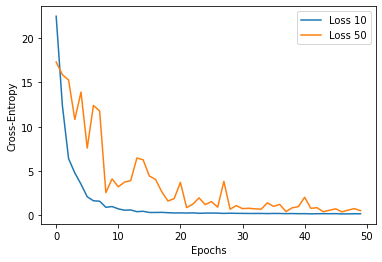

In [ ]:
plt.plot(history1['loss'], label='Loss 10')
plt.plot(history2['loss'], label='Loss 50')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

6168/6168 [==============================] - 0s 20us/step
Loss 0.302110, Accuracy 0.859598
Loss 0.133760, Accuracy 0.958009


In [ ]:
y_pred = model1.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7761024643320363
F1-score [0.87291801 0.0599047 ]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4743
           1       1.00      0.03      0.06      1425

    accuracy                           0.78      6168
   macro avg       0.89      0.52      0.47      6168
weighted avg       0.83      0.78      0.69      6168



In [ ]:
model3 = build_model()

history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=10).history

Train on 14392 samples, validate on 6168 samples
Epoch 1/200
14392/14392 [==============================] - 2s 150us/step - loss: 18.8572 - accuracy: 0.6677 - val_loss: 9.7735 - val_accuracy: 0.2403
Epoch 2/200
14392/14392 [==============================] - 2s 145us/step - loss: 8.8977 - accuracy: 0.7030 - val_loss: 2.3848 - val_accuracy: 0.8231
Epoch 3/200
14392/14392 [==============================] - 2s 153us/step - loss: 6.0894 - accuracy: 0.7225 - val_loss: 1.7250 - val_accuracy: 0.6034
Epoch 4/200
14392/14392 [==============================] - 2s 147us/step - loss: 2.6577 - accuracy: 0.7752 - val_loss: 1.2010 - val_accuracy: 0.7030
Epoch 5/200
14392/14392 [==============================] - 2s 146us/step - loss: 2.3021 - accuracy: 0.7901 - val_loss: 1.2479 - val_accuracy: 0.8497
Epoch 6/200
14392/14392 [==============================] - 2s 164us/step - loss: 1.5981 - accuracy: 0.8102 - val_loss: 0.2343 - val_accuracy: 0.8813
Epoch 7/200
14392/14392 [==============================]

In [ ]:
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))

6168/6168 [==============================] - 0s 18us/step
Loss 0.302110, Accuracy 0.859598
Loss 0.133760, Accuracy 0.958009
Loss 0.050619, Accuracy 0.988975


Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Cross-Entropy')

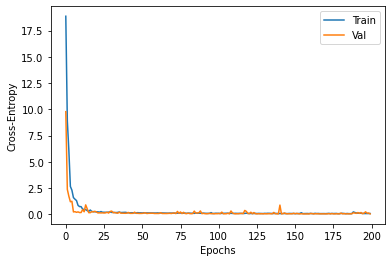

In [ ]:
plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=50)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

model4 = build_model()
history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, 
                      batch_size=10, callbacks=[es,mc]).history

Train on 11513 samples, validate on 2879 samples
Epoch 1/150
11513/11513 [==============================] - 2s 149us/step - loss: 11.7882 - accuracy: 8.6858e-05 - val_loss: 11.7534 - val_accuracy: 0.0000e+00
Epoch 2/150
11513/11513 [==============================] - 2s 137us/step - loss: 11.7839 - accuracy: 0.0000e+00 - val_loss: 11.7534 - val_accuracy: 0.0000e+00
Epoch 3/150
11513/11513 [==============================] - 2s 141us/step - loss: 11.7839 - accuracy: 0.0000e+00 - val_loss: 11.7534 - val_accuracy: 0.0000e+00
Epoch 4/150
11513/11513 [==============================] - 2s 139us/step - loss: 11.7839 - accuracy: 0.0000e+00 - val_loss: 11.7534 - val_accuracy: 0.0000e+00
Epoch 5/150
11513/11513 [==============================] - 2s 139us/step - loss: 11.7839 - accuracy: 0.0000e+00 - val_loss: 11.7534 - val_accuracy: 0.0000e+00
Epoch 6/150
11513/11513 [==============================] - 2s 141us/step - loss: 11.7839 - accuracy: 0.0000e+00 - val_loss: 11.7534 - val_accuracy: 0.0000e+

In [ ]:
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

6168/6168 [==============================] - 0s 18us/step
Loss 0.302110, Accuracy 0.859598
Loss 0.133760, Accuracy 0.958009
Loss 0.050619, Accuracy 0.988975
Loss 0.239337, Accuracy 0.886673


In [ ]:
from keras.regularizers import l2

def build_L2_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,), kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_loss', save_best_only=True)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                    batch_size=10, callbacks=[es,mc]).history

Train on 11513 samples, validate on 2879 samples
Epoch 1/100
11513/11513 [==============================] - 2s 185us/step - loss: 8.9987 - accuracy: 0.0269 - val_loss: 0.5618 - val_accuracy: 0.7708
Epoch 2/100
11513/11513 [==============================] - 2s 170us/step - loss: 0.5470 - accuracy: 0.7685 - val_loss: 0.5478 - val_accuracy: 0.7708
Epoch 3/100
11513/11513 [==============================] - 2s 172us/step - loss: 0.5406 - accuracy: 0.7685 - val_loss: 0.5319 - val_accuracy: 0.7708
Epoch 4/100
11513/11513 [==============================] - 2s 172us/step - loss: 0.5373 - accuracy: 0.7685 - val_loss: 0.5339 - val_accuracy: 0.7708
Epoch 5/100
11513/11513 [==============================] - 2s 174us/step - loss: 0.5362 - accuracy: 0.7709 - val_loss: 0.5283 - val_accuracy: 0.7819
Epoch 6/100
11513/11513 [==============================] - 2s 173us/step - loss: 0.5347 - accuracy: 0.7741 - val_loss: 0.5287 - val_accuracy: 0.7787
Epoch 7/100
11513/11513 [==============================] 

In [ ]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=100, batch_size=10, callbacks=[es,mc]).history

Train on 11513 samples, validate on 2879 samples
Epoch 1/100
11513/11513 [==============================] - 2s 204us/step - loss: 11.7467 - accuracy: 3.4743e-04 - val_loss: 11.7534 - val_accuracy: 0.0000e+00
Epoch 2/100
11513/11513 [==============================] - 2s 186us/step - loss: 11.7839 - accuracy: 0.0000e+00 - val_loss: 11.7534 - val_accuracy: 0.0000e+00
Epoch 3/100
11513/11513 [==============================] - 2s 187us/step - loss: 11.7839 - accuracy: 0.0000e+00 - val_loss: 11.7534 - val_accuracy: 0.0000e+00
Epoch 4/100
11513/11513 [==============================] - 2s 188us/step - loss: 11.7839 - accuracy: 0.0000e+00 - val_loss: 11.7534 - val_accuracy: 0.0000e+00
Epoch 5/100
11513/11513 [==============================] - 2s 204us/step - loss: 11.7839 - accuracy: 0.0000e+00 - val_loss: 11.7534 - val_accuracy: 0.0000e+00
Epoch 6/100
11513/11513 [==============================] - 2s 192us/step - loss: 11.7839 - accuracy: 0.0000e+00 - val_loss: 11.7534 - val_accuracy: 0.0000e+

In [ ]:
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

6168/6168 [==============================] - 0s 26us/step


In [ ]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

Loss 0.161087, Accuracy 0.944066
Loss 11.726190, Accuracy 0.231031
Loss 11.726190, Accuracy 0.000000


In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
def build_model(n_layers=2, h_dim=64, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [ ]:
n_layers = [1, 2, 3]
h_dim = [32, 64, 128]
activation = ['relu', 'tanh']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [ ]:
model = KerasRegressor(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3)
rnd_result = rnd.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

3837/3837 [==============================] - 0s 25us/step


In [ ]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 6.409853 using {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 32, 'activation': 'relu'}
6.409853 (3.884181) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 32, 'activation': 'relu'}
11.719399 (0.129853) with: {'optimizer': 'adagrad', 'n_layers': 2, 'h_dim': 128, 'activation': 'relu'}
11.719399 (0.129853) with: {'optimizer': 'adagrad', 'n_layers': 2, 'h_dim': 64, 'activation': 'relu'}
11.719399 (0.129853) with: {'optimizer': 'adagrad', 'n_layers': 3, 'h_dim': 64, 'activation': 'tanh'}
9.060630 (3.822459) with: {'optimizer': 'adam', 'n_layers': 3, 'h_dim': 64, 'activation': 'relu'}


In [ ]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))

6168/6168 [==============================] - 0s 19us/step
Loss 3.563643, Accuracy 0.000000
